- 가장 성능 좋았던 05번 모델 구조 기반 + class_weight 적용 test

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-13 14:24:54.966978: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 14:24:55.008346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 14:24:55.008398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 14:24:55.011335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 14:24:55.023809: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("GPU 사용 가능 여부:", tf.config.list_physical_devices("GPU"))

GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [4]:
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss="binary_crossentropy", metrics=["accuracy"])

2025-06-13 14:25:03.505957: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 14:25:03.506040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 14:25:03.506076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 14:25:03.663379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 14:25:03.663435: I external/local_xla/xla/stream_executor

In [ ]:
# 학습 -> class_weight 적용
class_weights={0: 1.5, 1: 1.0}  # closed에 더 집중

history=model.fit(train_generator, validation_data=val_generator,
                  epochs=20, verbose=1, class_weight=class_weights)

Epoch 1/20


2025-06-13 14:25:05.733427: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-13 14:25:06.041281: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-06-13 14:25:06.041319: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-06-13 14:25:06.041382: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-06-13 14:25:06.878811: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-06-13 14:25:07.040012: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

1200/1200 [==============================] - 43s 33ms/step - loss: 0.4572 - accuracy: 0.8921 - val_loss: 1.3541 - val_accuracy: 0.5839
Epoch 2/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.3127 - accuracy: 0.9298 - val_loss: 0.6053 - val_accuracy: 0.7672
Epoch 3/20
1200/1200 [==============================] - 26s 21ms/step - loss: 0.2581 - accuracy: 0.9522 - val_loss: 0.5761 - val_accuracy: 0.7600
Epoch 4/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.2188 - accuracy: 0.9643 - val_loss: 0.3214 - val_accuracy: 0.9199
Epoch 5/20
1200/1200 [==============================] - 26s 21ms/step - loss: 0.2108 - accuracy: 0.9696 - val_loss: 0.5893 - val_accuracy: 0.7558
Epoch 6/20
1200/1200 [==============================] - 26s 21ms/step - loss: 0.1927 - accuracy: 0.9726 - val_loss: 0.7965 - val_accuracy: 0.8067
Epoch 7/20
1200/1200 [==============================] - 26s 21ms/step - loss: 0.1870 - accuracy: 0.9739 - val_loss: 0.5919 - val_accura

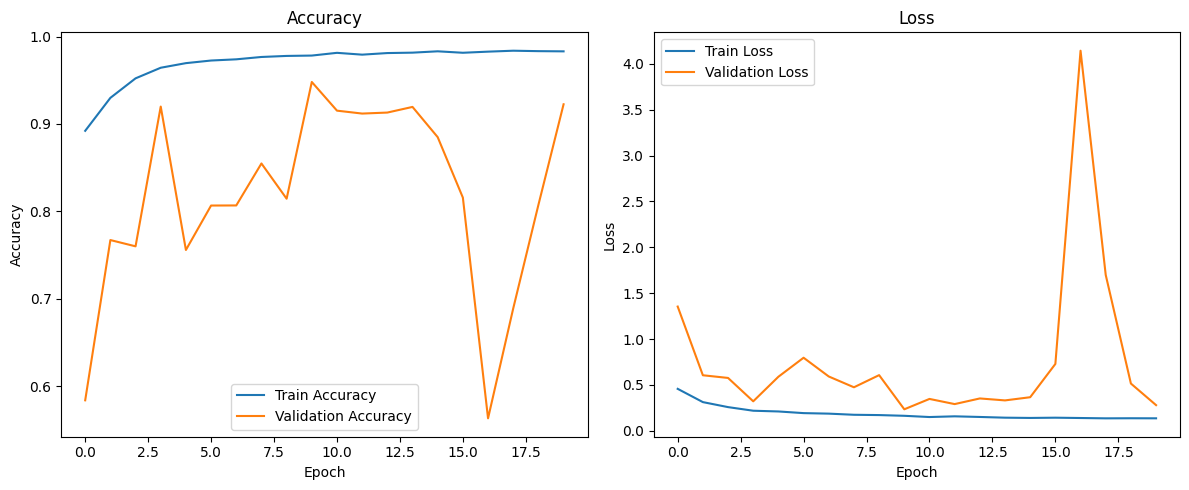

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/01_weight_tuned_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.88      0.98      0.93      4800
        open       0.97      0.87      0.92      4800

    accuracy                           0.92      9600
   macro avg       0.93      0.92      0.92      9600
weighted avg       0.93      0.92      0.92      9600



2025-06-13 14:37:50.487408: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13487304415144049785


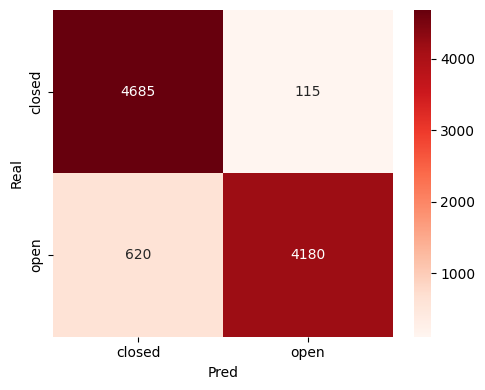

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

# classification report
report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)
with open("../../results/reports/01_weight_tuned_classification_report.txt", "w") as f:
    f.write(report)

# confusion matrix
conf_matirx=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matirx, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/01_weight_tuned_confusion_matrix.png")
plt.show()

- 05번 모델보다 낮아짐  
- 모델 저장 X